In [246]:
## Description: Impact of management training study
# Random assignment of maangers into or not into management training
# Measure the outcome of engagement of employees from the managers
# Some managers received the training even though not assigned to it - randomization not valid

## Sources: Causal Inference in Python


In [247]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix
from joblib import Parallel, delayed # for parallel processing
from toolz import partial
from dowhy import CausalModel

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [248]:
# treatment is intervention, outcome is engagement_score, rest of vars are covariates
# reduce or even eliminate the bias when estimating the causal relationship between management training and employee engagement
df = pd.read_csv("management_training.csv")
df.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843


In [249]:
df.shape

In [250]:
df.dtypes

departament_id             int64
intervention               int64
engagement_score         float64
tenure                     int64
n_of_reports               int64
gender                     int64
role                       int64
last_engagement_score    float64
department_score         float64
department_size            int64
dtype: object

In [251]:
# df['intervention'] = df['intervention'].astype('str')
df['intervention'] = df['intervention'].astype('bool')

In [252]:
df['engagement_score'].describe()

count    1.039100e+04
mean     3.829313e-17
std      1.000000e+00
min     -3.111431e+00
25%     -7.033152e-01
50%     -3.449486e-02
75%      6.724723e-01
max      3.563639e+00
Name: engagement_score, dtype: float64

#### Naive Estimate of Average Treatment Effect (ATE)

In [253]:
treatment_avg = df.loc[df['intervention'] == 1,'engagement_score'].mean()
control_avg = df.loc[df['intervention'] == 0,'engagement_score'].mean()

print('Treatment Average:', treatment_avg.round(4))
print('Control Average:',  control_avg.round(4))
print('Treatment Effect:', (treatment_avg - control_avg).round(4))

Treatment Average: 0.1999
Control Average: -0.2347
Treatment Effect: 0.4346


### DoWhy: Graphical Causal Model Model based Inference)

In [254]:
# Graph Modeling Language (GML)
nodes = ['engagement_score','intervention','tenure','last_engagement_score','department_score','department_size','n_of_reports', 'gender', 'role']
edges = [
    ('tenure', 'engagement_score'),
    ('last_engagement_score', 'engagement_score'),
    ('department_score', 'engagement_score'),
    ('department_size', 'engagement_score'),
    ('n_of_reports', 'engagement_score'),
    ('gender', 'engagement_score'),
    ('role', 'engagement_score'),
    
    ('intervention', 'engagement_score'),

    ('tenure', 'intervention'), # confounders
    ('last_engagement_score', 'intervention'),
    ('department_score', 'intervention'),
    ('department_size', 'intervention'),
    ('n_of_reports', 'intervention'),
    ('gender', 'intervention'),
    ('role', 'intervention'),

    ('n_of_reports', 'tenure'),
    ('tenure', 'role'),
    ('n_of_reports', 'role')

]

# Generate the GML graph
gml_string = 'graph [directed 1\n'
for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'
for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target"{edge[1]}"]\n'
gml_string += ']'

In [255]:
df['intervention'].unique()

array([ True, False])

In [256]:
# Can add common causes, effect modifiers, instrumental vars
# common causes = covariates, vars with more than 1 effect
model = CausalModel(
    data = df,
    treatment = 'intervention',
    outcome = 'engagement_score',
    graph=gml_string
)

Model to find the causal effect of treatment ['intervention'] on outcome ['engagement_score']


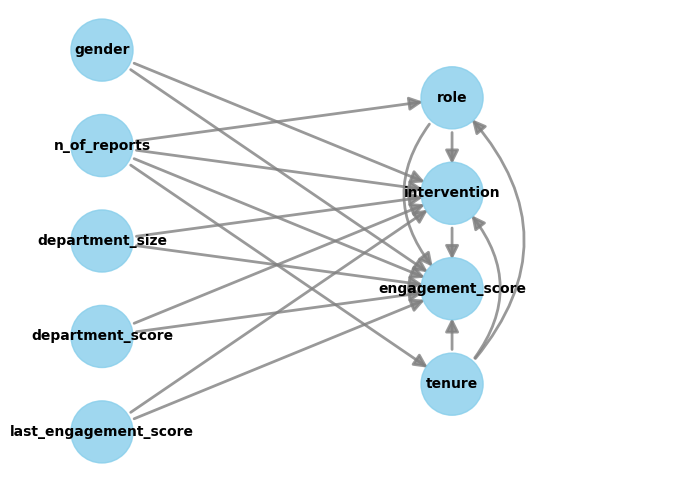

In [257]:
model.interpret()

In [258]:
estimand = model.identify_effect(proceed_when_unidentifiable=True) # proceed_when_unidentifiable ignore any unobserved confounding
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[engagement_score|last_engagement_score,department_score,depa
d[intervention]                                                               

                                             
rtment_size,n_of_reports,tenure,role,gender])
                                             
Estimand assumption 1, Unconfoundedness: If U→{intervention} and U→engagement_score then P(engagement_score|intervention,last_engagement_score,department_score,department_size,n_of_reports,tenure,role,gender,U) = P(engagement_score|intervention,last_engagement_score,department_score,department_size,n_of_reports,tenure,role,gender)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### Distance Matching

In [259]:
causal_estimate_dmatch  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

print('Distance Matching ATE:', round(causal_estimate_dmatch.value,4))

Distance Matching ATE: 0.294


In [260]:
print(causal_estimate_dmatch)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[engagement_score|last_engagement_score,department_score,depa
d[intervention]                                                               

                                             
rtment_size,n_of_reports,tenure,role,gender])
                                             
Estimand assumption 1, Unconfoundedness: If U→{intervention} and U→engagement_score then P(engagement_score|intervention,last_engagement_score,department_score,department_size,n_of_reports,tenure,role,gender,U) = P(engagement_score|intervention,last_engagement_score,department_score,department_size,n_of_reports,tenure,role,gender)

## Realized estimand
b: engagement_score~intervention+last_engagement_score+department_score+department_size+n_of_reports+tenure+role

#### Linear Regression

In [261]:
causal_estimate_linreg  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression',
    test_significance=True)

print('Linear Regression ATE:', round(causal_estimate_linreg.value,4))

Linear Regression ATE: 0.272


#### Propensity Score Stratification

In [262]:
causal_estimate_pstrat  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_matching',
    target_units='ate')

print('Propensity Score Stratification ATE:', round(causal_estimate_pstrat.value,4))

c:\Users\arsep\anaconda3\envs\ds1\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Propensity Score Stratification ATE: 0.2945


#### Propensity Score Matching

In [263]:
causal_estimate_pmatching  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_stratification',
    target_units='ate')

print('Propensity Score Matching ATE:', round(causal_estimate_pmatching.value,4))

Propensity Score Matching ATE: 0.3084


### Propensity Score Weighting

In [264]:
causal_estimate_weighting  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_weighting',
    target_units='ate',
    method_params={"weighting_scheme":"ips_weight"})

print('Weighting ATE:', round(causal_estimate_weighting.value,4))

Weighting ATE: 0.3135


### Other Packages

#### Linear Regression Modeling

In [89]:
df['intervention'] = df['intervention'].astype('int')

In [90]:
# simple model comparing treatment vs. control
smf.ols("engagement_score ~ intervention",data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2347,0.014,-16.619,0.000,-0.262,-0.207
intervention,0.4346,0.019,22.616,0.000,0.397,0.472


In [91]:
# full regression model
# much smaller ATE than previous simple model
model = smf.ols("""engagement_score ~ intervention + tenure + last_engagement_score + department_score + n_of_reports + C(gender) + C(role)""", data=df).fit()

print("ATE:", model.params["intervention"])
print("95% CI:", model.conf_int().loc["intervention", :].values.T)

ATE: 0.26779085766768534
95% CI: [0.23357751 0.30200421]


#### Propensity Score Weighting

In [92]:
# propensity score model
ps_model = smf.logit("""intervention ~ tenure + last_engagement_score + department_score + C(n_of_reports) + C(gender) + C(role)""", data=df).fit(disp=0)

In [93]:
# propensity scores
data_ps = df.assign(propensity_score = ps_model.predict(df),)
data_ps[["intervention", "engagement_score", "propensity_score"]].head()

,intervention,engagement_score,propensity_score
0,1,0.277359,0.596106
1,1,-0.449646,0.391138
2,1,0.769703,0.602578
3,1,-0.121763,0.580990
4,1,1.526147,0.619976


In [94]:
data_ps.shape

In [95]:
# adding propensity_score var to simple regression model to avoid adjusting for the confounders of X
# ATE is very similar to full model
model = smf.ols("engagement_score ~ intervention + propensity_score",data=data_ps).fit()
model.params["intervention"]

#### Propensity Score Matching

In [96]:


T = "intervention"
X = "propensity_score"
Y = "engagement_score"

treated = data_ps.query(f"{T}==1")
untreated = data_ps.query(f"{T}==0")

# KNeighborsRegressor regression based on KNN
# find the nearest 1 n_neighbors match, KNN model with propensity_score as only feature to predict engagement_score

# control data model
mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[[X]],untreated[Y])

# treatment data model
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[[X]],treated[Y])

predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model, match is the prediction of engagement_score for each row
    treated.assign(match=mt0.predict(treated[[X]])), # assign new cols to df (match col)
    
    # find matches for the untreated looking at the treated knn model
    untreated.assign(match=mt1.predict(untreated[[X]]))
])

predicted.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size,...,ips_weight,tips_weight,cips_weight,ips_normalized_weight,tips_normalized_weight,cips_normalized_weight,ips_stabilized_weight,tips_stabilized_weight,cips_stabilized_weight,match
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843,...,1.643192,1.0,0.643192,0.000157,0.000178,0.000133,0.887302,0.539987,0.347315,0.557680
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843,...,2.444262,1.0,1.444262,0.000234,0.000178,0.000299,1.319868,0.539987,0.779882,-0.952622
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843,...,1.622321,1.0,0.622321,0.000155,0.000178,0.000129,0.876031,0.539987,0.336045,-0.618381
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843,...,1.694261,1.0,0.694261,0.000162,0.000178,0.000144,0.914878,0.539987,0.374892,-1.404962
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843,...,1.585665,1.0,0.585665,0.000152,0.000178,0.000121,0.856238,0.539987,0.316251,0.000354


In [97]:
predicted.loc[predicted['engagement_score'] == predicted['engagement_score'][2],:]
# predicted.head()
# predicted['engagement_score'].head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size,...,ips_weight,tips_weight,cips_weight,ips_normalized_weight,tips_normalized_weight,cips_normalized_weight,ips_stabilized_weight,tips_stabilized_weight,cips_stabilized_weight,match
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843,...,1.622321,1.0,0.622321,0.000155,0.000178,0.000129,0.876031,0.539987,0.336045,-0.618381


In [98]:
predicted.loc[predicted['match'] == predicted['engagement_score'][2],:]

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size,...,ips_weight,tips_weight,cips_weight,ips_normalized_weight,tips_normalized_weight,cips_normalized_weight,ips_stabilized_weight,tips_stabilized_weight,cips_stabilized_weight,match
4993,63,0,1.111142,6,2,2,4,0.956035,0.196662,389,...,2.636657,1.636657,1.0,0.000255,0.000294,0.000209,1.212898,0.752884,0.460013,0.769703
5698,58,0,0.180531,6,4,1,1,-0.349523,-0.946657,1732,...,2.620591,1.620591,1.0,0.000253,0.000291,0.000209,1.205507,0.745494,0.460013,0.769703
7128,37,0,-0.618381,6,4,1,1,-0.173646,-0.045722,530,...,2.554156,1.554156,1.0,0.000247,0.000279,0.000209,1.174946,0.714933,0.460013,0.769703


In [99]:
# Every unit is matched, now find estimated ATE
# (Y - Y_Predicted) * Intervention + (Y_Predicted - Y) * (1 - Intervention)
np.mean((predicted[Y] - predicted["match"])*predicted[T] + (predicted["match"] - predicted[Y])*(1-predicted[T]))

#### Inverse Propensity Weighting

In [100]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
t1 = data_ps.query("intervention==1")["engagement_score"] 
t0 = data_ps.query("intervention==0")["engagement_score"] 

y1 = sum(t1*weight_t)/len(data_ps)
y0 = sum(t0*weight_nt)/len(data_ps)

print("E[Y1]:", y1)
print("E[Y0]:", y0)
print("ATE", y1 - y0)

E[Y1]: 0.11656317232946753
E[Y0]: -0.1494155364781441
ATE 0.26597870880761165


In [101]:
# Alternative ATE calculation
np.mean(data_ps["engagement_score"] * (data_ps["intervention"] - data_ps["propensity_score"]) / (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

In [102]:
# Unfortunately, computing the standard error for IPW is not as straightforward as with linear regression. 
# The most straightforward way to obtain a confidence interval around your IPW estimate is by using the bootstrap method. 
# With this method, you will repeatedly resample the data with replacement to obtain multiple IPW estimators. 
# You can then calculate the 2.5th and 97.5th percentiles of these estimates to obtain a 95% confidence interval.

In [103]:
# define function that computes the IPW estimator
def est_ate_with_ps(df, ps_formula, T, Y):
    
    X = dmatrix(ps_formula, df)
    ps_model = LogisticRegression(penalty="l2",max_iter=1000).fit(X, df[T])
    ps = ps_model.predict_proba(X)[:, 1]
    
    # compute the ATE
    return np.mean((df[T]-ps) / (ps*(1-ps)) * df[Y]) 

In [104]:
formula = """tenure + last_engagement_score + department_score+ C(n_of_reports) + C(gender) + C(role)""" 
T = "intervention"
Y = "engagement_score"

est_ate_with_ps(df, formula, T, Y)

In [105]:
def bootstrap(data, est_fn, rounds=200, seed=123, pcts=[2.5, 97.5]):
    np.random.seed(seed)
    
    stats = Parallel(n_jobs=4)(
        delayed(est_fn)(data.sample(frac=1, replace=True))
        for _ in range(rounds)
    )
    
    return np.percentile(stats, pcts)

In [106]:
def addNumber(x, number):
    return x + number

add2 = partial(addNumber, number=2)
add4 = partial(addNumber, number=4)

In [107]:
# add2(3)
add4(3)

In [108]:
from toolz import partial

print(f"ATE: {est_ate_with_ps(df, formula, T, Y)}")

est_fn = partial(est_ate_with_ps, ps_formula=formula, T=T, Y=Y)
print(f"95% C.I.: ", bootstrap(df, est_fn))

ATE: 0.2662350402507956


95% C.I.:  [0.22654202 0.30087918]
